# Features Exploration

In this notebook we explore the features to be extracted and tested in the different models. As in the `DataProcessor` class, we will eventually create a class for feature extraction ( `on-loading` extraction ).

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import cv2
import os

BASE_DATA_DIR = os.path.join('data', 'train')
TRAINING_SET_FILE = os.path.join('data', 'training_set.csv')

Define the data loading scheme:

In [5]:
from codes.preprocessing import DataProcessor

# load training data
training_data = pd.read_csv( TRAINING_SET_FILE )

# define the preprocessing scheme
settings = { 'image_size': (256, 256), 'noise': True, 'invert': True, 'sharpening': True }
data_processor = DataProcessor(data_dir=BASE_DATA_DIR, settings=settings)

Let's define and visualise some relevant features:

In [203]:
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
from skimage.measure import moments_central, moments_normalized
from skimage import filters, morphology
from scipy import stats

def compute_binary_img( image ):
    """ Computes the binary [0 and 1] of the image, showing the contours and closing some imperfections. """
    binary = img > filters.threshold_otsu(img)
    clean = morphology.remove_small_objects(binary, binary.size // 100.0, connectivity=2)
    closed = morphology.binary_closing(clean)
    region = morphology.remove_small_holes(closed, binary.size // 100.0, connectivity=2).astype( np.float32 )
    return cv2.normalize( region, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

def extract_hu_moments( image ):
    """ Calculate Hu Moments """
    moments = cv2.moments( image )
    hu_moments = cv2.HuMoments( moments ).flatten()
    return hu_moments

def extract_flusser_moments( image ):
    """ Calculate the Flusser moments from the image """
    moments = moments_central(image, order=3)
    normalized_moments = moments_normalized(moments)
    return normalized_moments.flatten()

def extract_fourier_descriptors( image, num_descriptors=30):
    """ Extract features from the Fourier transform of the image """    
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        contour = contours[0]
        contour = contour[:, 0, :]
        fourier_coeffs = np.fft.fft(contour, axis=0)[:num_descriptors]
        return fourier_coeffs.flatten()
    else:
        return []

def extract_gabor_features(image, num_orientations=8, num_scales=4):
    """ Calculate features from applying Gabor filters to the image """
    filter_scale = 3 if image.shape[0] <= 256 else 5

    # create combinations of rotations and scales
    combinations_values = []    
    for theta in np.arange(start=0, stop=np.pi, step=(np.pi / num_orientations)):
        for sigma in range(1, num_scales + 1):
            
            # get the gabor kernel from cv2 and convolve it with the image
            filter_ksize = filter_scale * sigma
            gabor_kernel = cv2.getGaborKernel((filter_ksize, filter_ksize), sigma, theta, 10 * sigma, 0.5, 0, ktype=cv2.CV_32F)
            gabor_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_kernel)
            combinations_values.append( gabor_image.mean() )
            
    # compute gabor features
    gmin, gmax = np.min( combinations_values ), np.max( combinations_values )
    gabor_features = [ *combinations_values, gmin, gmax, (gmax - gmin) / gmin]
    return np.array( gabor_features )

def extract_basic_intensity_statistics(image):
    """ Perform some basic pixel intensity statistics """
    mean = np.mean(image)
    std = np.std(image)
    kurtosis = stats.kurtosis(image.flatten())
    skew = stats.skew(image.flatten())
    return np.array( [mean, std, kurtosis, skew] )

def extract_local_binary_patterns(image, num_points=24, radius=3):
    """ Computes the LBP image and then extracts the relevant histograms from it."""
    lbp_image = local_binary_pattern(image, num_points, radius, method="uniform")
    hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_histogram_of_oriented_gradients(image, num_bins=8):
    """ It selects a cell size depending on the image_size and compute the HOG"""
    ksize = 24 if image.shape[0] <= 256 else 32
    hog_features = hog( image, orientations=num_bins, pixels_per_cell=(ksize, ksize), cells_per_block=(1, 1))
    return hog_features

def extract_haralick_features( image ):
    """ Calculates the gray co-occurence matrix of the image. From the co-matrix, calculates the
        relevant features.
    """
    angles = [ i * (np.pi / 4) for i in range(4) ]
    graycomat = graycomatrix(image, distances=[1], angles=angles)
    
    haralick_features = []
    for prop_name in ["contrast", "dissimilarity", "homogeneity", "energy", "correlation"]:
        feature = graycoprops(graycomat, prop_name).ravel()
        haralick_features.extend( feature )
    return np.array( haralick_features )


Geometric Features shape: (151,)
Intensity Features shape: (215,)
Texture Features shape: (846,)
Geometric Features shape: (151,)
Intensity Features shape: (215,)
Texture Features shape: (846,)
Geometric Features shape: (151,)
Intensity Features shape: (215,)
Texture Features shape: (846,)
Geometric Features shape: (151,)
Intensity Features shape: (215,)
Texture Features shape: (846,)
Geometric Features shape: (151,)
Intensity Features shape: (215,)
Texture Features shape: (846,)


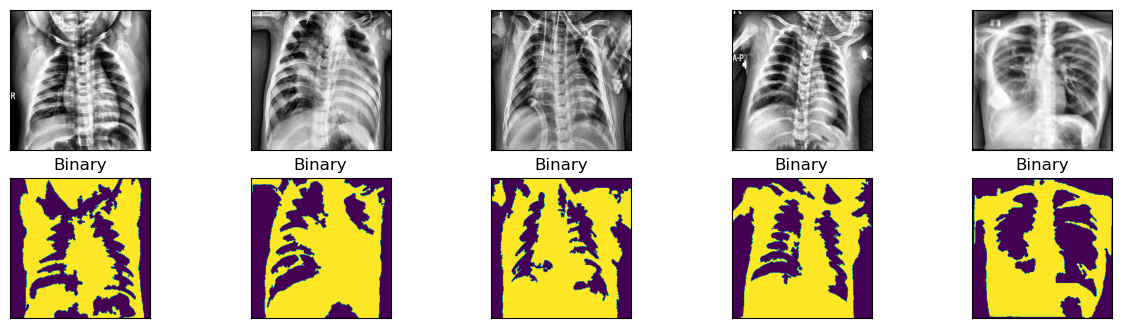

In [209]:
SAMPLE_SIZE = 5

random_samples = np.random.choice( training_data['file'].values, size=SAMPLE_SIZE, replace=False,  )
np.random.shuffle( random_samples )

fig, ax = plt.subplots(2, 5, figsize=(15, 4))
for num in range( SAMPLE_SIZE ):    
    img = data_processor.read_image( random_samples[num] )
    img = data_processor.apply_preprocessing( img )
    ax[0, num].imshow(img, cmap='gray'), ax[0, num].set_xticks([]), ax[0, num].set_yticks([])
    
    binary_image = compute_binary_img( img )
    
    # extract features
    hu_moments = extract_hu_moments( img )
    flusser_moments = extract_flusser_moments( img )
    fourier_features = extract_fourier_descriptors( binary_image, num_descriptors=64 )
    geometric_features = np.concatenate([ hu_moments, flusser_moments, fourier_features ])
    print("Geometric Features shape:", geometric_features.shape)
    
    gabor_features = extract_gabor_features( img, num_orientations=26, num_scales=8)
    basic_features = extract_basic_intensity_statistics( img )
    intensity_features = np.concatenate([ gabor_features, basic_features])
    print("Intensity Features shape:", intensity_features.shape)
    
    lbp_features = extract_local_binary_patterns( img )
    hog_features = extract_histogram_of_oriented_gradients( img )
    haralick_features = extract_haralick_features( img )    
    texture_features = np.concatenate([ lbp_features, hog_features, haralick_features])
    print("Texture Features shape:", texture_features.shape)
    
    # concatenate all features
    ax[1, num].imshow(binary_image), ax[1, num].set_xticks([]), ax[1, num].set_yticks([])
    ax[1, num].set_title('Binary')
    
    
plt.show()